# XGBoost

In [1]:
! pip list | grep xgboost

xgboost                 1.5.2


## Load and investigate the iris dataset

In [2]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
# extract 'petal length (cm)' and 'petal width (cm)'
X = iris.data[:, [2, 3]]
# ['setosa' 'versicolor' 'virginica']
y = iris.target

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.16, random_state=1, stratify=y_train)
print(len(y_train), len(y_val), len(y_test))

100 20 30


In [4]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# To check recent matplotlib compatibility
import matplotlib
from distutils.version import LooseVersion


def prob2index(prob):
    return np.array([np.argmax(ps) for ps in prob])

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(xgb.DMatrix(np.array([xx1.ravel(), xx2.ravel()]).T))
    Z = prob2index(Z)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    color=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        
        if LooseVersion(matplotlib.__version__) < LooseVersion('0.3.4'):
            plt.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='',
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100, 
                        label='test set')
        else:
            plt.scatter(X_test[:, 0],
                        X_test[:, 1],
                        c='none',
                        edgecolor='black',
                        alpha=1.0,
                        linewidth=1,
                        marker='o',
                        s=100, 
                        label='test set')   

[0]	train-mlogloss:0.96854	eval-mlogloss:0.97734
[1]	train-mlogloss:0.85929	eval-mlogloss:0.87612
[2]	train-mlogloss:0.76628	eval-mlogloss:0.79053
[3]	train-mlogloss:0.68627	eval-mlogloss:0.71788
[4]	train-mlogloss:0.61698	eval-mlogloss:0.65460
[5]	train-mlogloss:0.55687	eval-mlogloss:0.60092
[6]	train-mlogloss:0.50413	eval-mlogloss:0.55433
[7]	train-mlogloss:0.45729	eval-mlogloss:0.51285
[8]	train-mlogloss:0.41617	eval-mlogloss:0.47751
[9]	train-mlogloss:0.37969	eval-mlogloss:0.44663


<ipython-input-4-55fb582a2255>:32: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[y == cl, 0],


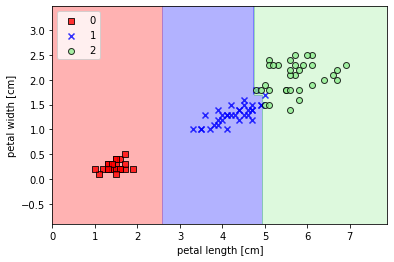

In [5]:
# https://xgboost.readthedocs.io/en/stable/index.html
import xgboost as xgb

# https://github.com/ghmagazine/kagglebook/tree/master/ch04-model-interface
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)
dtest  = xgb.DMatrix(X_test)

param = {
    # When used with multi-class classification, objective should be multi:softprob
    # instead of multi:softmax, as the latter doesn’t output probability.
    'objective':'multi:softprob',
    'eval_metric': 'mlogloss',
    'num_class': len(iris['target_names']),
    'max_depth': 3,
    'eta': 0.1,
    'verbosity': 1,
    'random_state': 71,
    #'gpu_id': 0,
    #'tree_method': 'gpu_hist',
}

watchlist = {(dtrain, 'train'), (dvalid, 'eval')}

# https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.training
bst = xgb.train(param, dtrain, num_boost_round=10, evals=watchlist, early_stopping_rounds=10)

plot_decision_regions(X_train, y_train, classifier=bst)
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.show()

In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = bst.predict(dtest)
y_pred = prob2index(y_pred)

# confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)

# accuracy
print(accuracy_score(y_pred, y_test))
print(np.trace(conf_mat) / len(y_test))

[[10  0  0]
 [ 0 10  0]
 [ 0  1  9]]
0.9666666666666667
0.9666666666666667
